In [1]:
#pip install matplotlib


In [25]:
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

class RoomDataProcessor:
    def __init__(self, json_dir, id_list_file):
        self.json_dir = json_dir
        self.id_list_file = id_list_file
        self.data_list = []

    def load_ids(self):
        with open(self.id_list_file, 'r') as f:
            self.ids = f.read().splitlines()

    def load_json_files(self):
        self.load_ids()
        for id in self.ids:
            file_path = os.path.join(self.json_dir, f"{id}.json")
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                data = self.process_json_data(json_data)
                self.data_list.append(data)

    def process_json_data(self, json_data):
        building_position = json_data.get('building_position', [1, 1, 1])

        positions = []
        edge_index = []
        objects = []
        labels = []  # 初始化标签
        region_index_map = {}  # 用于映射房间的 region_index
        
        rooms = json_data['rooms']
        
        for room_index, room in enumerate(rooms):
            xlo, ylo, zlo, xhi, yhi, zhi = room['bbox']
            width = xhi - xlo
            height = yhi - zlo

            room_position = [xlo / max(building_position[0], 1e-6), 
                             ylo / max(building_position[1], 1e-6)]
            region_index_map[room['region_index']] = room_index  # 映射 region_index 到 room_index
            
            # 处理 objects 数据
            if 'objects' in room:
                for obj in room['objects']:
                    obj_pos = [obj['position'][0] / max(building_position[0], 1e-6), 
                               obj['position'][1] / max(building_position[1], 1e-6)]
                    a0 = obj['axis_directions(a0)'][:2]  
                    a1 = obj['axis_directions(a1)'][:2]  
                    radii = obj['radii(r)']

                    category_index = obj['category_index']
                    
                    # 检查并忽略 category_index 为 -1 的数据点
                    if category_index == -1:
                        #print(f"Warning: Ignoring object with -1 category_index at position {obj_pos}")
                        continue 
                    positions.append(obj_pos)
                    labels.append(category_index)  # 使用类别索引作为标签
                    objects.append((obj_pos, a0, a1, radii, category_index))

        # 构建 edge_index 以表示 objects 之间的关系（基于 object_index）
        if objects:
            for i, obj1 in enumerate(objects):
                for j, obj2 in enumerate(objects):
                    if i != j and obj1[-1] == obj2[-1]:  # 如果两个 object 属于同一类别
                        edge_index.append([i, j])
        x = torch.tensor(positions, dtype=torch.float)  # 只存储位置
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        y = torch.tensor(labels, dtype=torch.long)  # 使用类别索引作为标签
        room_edge_index = []
        room_labels = []
        for room in rooms:
            src = region_index_map[room['region_index']]
            dst = src  # 连接到自身
            room_edge_index.append([src, dst])
            room_labels.append(room['level_index'])  # 使用 level_index 作为房间的标签

        room_edge_index = torch.tensor(room_edge_index, dtype=torch.long).t().contiguous()
        room_labels = torch.tensor(room_labels, dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y), Data(x=torch.tensor(positions, dtype=torch.float),
                                                          edge_index=room_edge_index, y=room_labels), objects

    def create_dataloader(self, batch_size=1):
        return DataLoader([(data, objects) for data, _, objects in self.data_list], batch_size=batch_size, shuffle=True)

    def draw_rooms_and_objects(self, index=0):
        if index < len(self.data_list):
            data, room_data, objects = self.data_list[index]
            plt.figure()
    
            # 绘制房间，根据 bbox 数据提取 size
            for i, (pos, room) in enumerate(zip(room_data.x, room_data.y)):
                # 提取 bbox 数据
                xlo, ylo, zlo, xhi, yhi, zhi = room_data[i]['bbox']  # 假设 bbox 是包含在 room_data.y 中
                width = xhi - xlo
                height = yhi - ylo  # 用于二维绘制
    
                # 使用房间的左下角坐标和尺寸绘制矩形
                plt.gca().add_patch(plt.Rectangle(
                    (xlo, ylo), width, height, edgecolor='black', facecolor='gray', alpha=0.5))
    
            # 为不同类别的物体分配不同的颜色
            category_colors = list(mcolors.TABLEAU_COLORS.values())  # 使用Matplotlib的颜色表
            num_categories = len(category_colors)
            
            # 绘制 objects as oriented bounding boxes (OBBs)
            for obj_pos, a0, a1, radii, category_index in objects:
                # 计算旋转矩形的四个顶点
                p0 = np.array(obj_pos) - radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p1 = np.array(obj_pos) + radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p2 = np.array(obj_pos) + radii[0] * np.array(a0) + radii[1] * np.array(a1)
                p3 = np.array(obj_pos) - radii[0] * np.array(a0) + radii[1] * np.array(a1)
                
                color = category_colors[category_index % num_categories]  # 分配颜色
    
                # 使用Polygon绘制旋转矩形
                polygon = Polygon([p0, p1, p2, p3], edgecolor=color, facecolor='none', linewidth=2, alpha=0.8)
                plt.gca().add_patch(polygon)
                plt.scatter(obj_pos[0], obj_pos[1], c=color, s=10)  # 绘制 object 的中心点
            
            plt.axis('equal')
            plt.title(f'Rooms and Objects (JSON File Index: {index})')
            plt.show()
        else:
            print("Index out of range. Please select a valid index.")

# 简单的图神经网络模型
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
'''
def train(model, data_loader, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        for batch in data_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = F.nll_loss(out, batch.y)  # 交叉熵损失
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
'''# tarin and validation 在后面
if __name__ == "__main__":
    json_dir = '../output'
    id_list_file = 'ID.txt'

    processor = RoomDataProcessor(json_dir, id_list_file)
    processor.load_json_files()
    # 创建 DataLoader，划分训练集和验证集
    train_data, val_data = split_data(processor.data_list)
    train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=4, shuffle=False)
    # 从 tuple 中提取 Data 对象
    in_channels = train_loader.dataset[0][0].x.shape[1]  # 输入特征数
    hidden_channels = 16  # 隐藏层大小
    max_label = max([data.y.max().item() for data, _, _ in processor.data_list])  # 正确解包三个值
    out_channels = max_label + 1  # 输出类别数 (根据实际情况修改)
    model = SimpleGCN(in_channels, hidden_channels, out_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    #train_and_evaluate(model, train_loader, val_loader, optimizer, num_epochs=20)
    processor.draw_rooms_and_objects(index=0)

KeyError: 0

<Figure size 640x480 with 0 Axes>

In [ ]:
processor.draw_rooms_and_objects(index=0)

In [3]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader

# 划分训练集和验证集
def split_data(data_list, test_size=0.2):
    train_data, val_data = train_test_split(data_list, test_size=test_size, random_state=42)
    return train_data, val_data

# 计算准确度
def calculate_accuracy(logits, labels):
    preds = logits.argmax(dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

# 修改后的训练函数，添加训练和验证准确度
def train_and_evaluate(model, train_loader, val_loader, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = F.nll_loss(out, batch.y, ignore_index=-1)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += calculate_accuracy(out, batch.y) * batch.y.size(0)
            train_total += batch.y.size(0)
        
        train_accuracy = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                out = model(batch)
                loss = F.nll_loss(out, batch.y, ignore_index=-1)
                val_loss += loss.item()
                val_correct += calculate_accuracy(out, batch.y) * batch.y.size(0)
                val_total += batch.y.size(0)
        
        val_accuracy = val_correct / val_total
        
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')


D:\Anaconda\envs\pytorch_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


AttributeError: 'tuple' object has no attribute 'x'

ValueError: not enough values to unpack (expected 5, got 2)

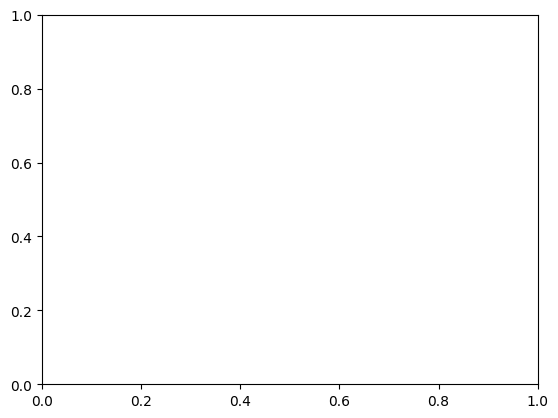

In [4]:
processor.draw_rooms_and_objects(index=0)

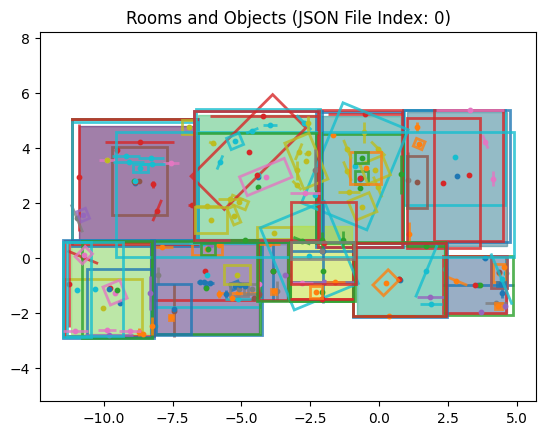

In [49]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon  # 导入 Polygon 用于绘制旋转矩形

class RoomDataProcessor:
    def __init__(self, json_dir, id_list_file):
        self.json_dir = json_dir
        self.id_list_file = id_list_file
        self.data_list = []

    def load_ids(self):
        with open(self.id_list_file, 'r') as f:
            self.ids = f.read().splitlines()

    def load_json_files(self):
        self.load_ids()
        for id in self.ids:
            file_path = os.path.join(self.json_dir, f"{id}.json")
            with open(file_path, 'r') as f:
                json_data = json.load(f)
                data = self.process_json_data(json_data)
                self.data_list.append(data)

    def process_json_data(self, json_data):
        building_position = json_data.get('building_position', [1, 1, 1])

        node_features = []
        edge_index = []
        bboxes = []
        objects = []
        
        rooms = json_data['rooms']
        
        for room_index, room in enumerate(rooms):
            # 提取 room 的 bbox 数据，并进行归一化计算
            xlo, ylo, zlo, xhi, yhi, zhi = room['bbox']
            width = xhi - xlo
            height = yhi - ylo

            room_position = [xlo / max(building_position[0], 1e-6), 
                             ylo / max(building_position[1], 1e-6)]
            node_features.append(room_position)
            bboxes.append((room_position, width / max(building_position[0], 1e-6), 
                           height / max(building_position[1], 1e-6)))
            
            # 处理 objects 数据
            if 'objects' in room:
                for obj in room['objects']:
                    obj_pos = [obj['position'][0] / max(building_position[0], 1e-6), 
                               obj['position'][1] / max(building_position[1], 1e-6)]
                    a0 = obj['axis_directions(a0)'][:2]  # 只取 a0 的前两个分量
                    a1 = obj['axis_directions(a1)'][:2]  # 只取 a1 的前两个分量
                    radii = obj['radii(r)']

                    objects.append((obj_pos, a0, a1, radii, obj['category_index']))

        # 构建 edge_index 以表示 objects 之间的关系（基于 category_index）
        if objects:
            for i, obj1 in enumerate(objects):
                for j, obj2 in enumerate(objects):
                    if i != j and obj1[-1] == obj2[-1]:  # 如果两个 object 属于同一类别
                        edge_index.append([i, j])

        x = torch.tensor([obj[0] for obj in objects], dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        y = None

        return Data(x=x, edge_index=edge_index, y=y), bboxes, objects

    def create_dataloader(self, batch_size=1):
        return DataLoader([data for data, _, _ in self.data_list], batch_size=batch_size, shuffle=True)

    def draw_rooms_and_objects(self, index=0):
        if index < len(self.data_list):
            data, bboxes, objects = self.data_list[index]
            plt.figure()

            # 绘制房间
            for i, (pos, width, height) in enumerate(bboxes):
                color = plt.cm.viridis(i / len(bboxes))
                plt.gca().add_patch(plt.Rectangle((pos[0], pos[1]), 
                                                  width, height, edgecolor=color, facecolor=color, alpha=0.5))

            # 为不同类别的物体分配不同的颜色
            category_colors = list(mcolors.TABLEAU_COLORS.values())  # 使用Matplotlib的颜色表
            num_categories = len(category_colors)
            
            # 绘制 objects as oriented bounding boxes (OBBs)
            for obj_pos, a0, a1, radii, category_index in objects:
                # 计算旋转矩形的四个顶点
                p0 = np.array(obj_pos) - radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p1 = np.array(obj_pos) + radii[0] * np.array(a0) - radii[1] * np.array(a1)
                p2 = np.array(obj_pos) + radii[0] * np.array(a0) + radii[1] * np.array(a1)
                p3 = np.array(obj_pos) - radii[0] * np.array(a0) + radii[1] * np.array(a1)
                
                color = category_colors[category_index % num_categories]  # 分配颜色

                # 使用Polygon绘制旋转矩形
                polygon = Polygon([p0, p1, p2, p3], edgecolor=color, facecolor='none', linewidth=2, alpha=0.8)
                plt.gca().add_patch(polygon)
                plt.scatter(obj_pos[0], obj_pos[1], c=color, s=10)  # 绘制 object 的中心点
            
            plt.axis('equal')
            plt.title(f'Rooms and Objects (JSON File Index: {index})')
            plt.show()
        else:
            print("Index out of range. Please select a valid index.")

# 使用示例
json_dir = '../output'
id_list_file = 'ID.txt'

processor = RoomDataProcessor(json_dir, id_list_file)
processor.load_json_files()

# 绘制第一个JSON文件中房间和objects的位置和大小
processor.draw_rooms_and_objects(index=0)
